In [63]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [16,5]
%config IPCompleter.greedy=True

## DNS data with variable thermophysical properties
 
             Created on: Dec, 2018
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Dec, 2018
                     by: Rene Pecnik 
                     
The paper in which the data has been published is give here: __[Pecnik and Patel, JFM, 2017](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/scaling-and-modelling-of-turbulence-in-variable-property-channel-flows/AC93677BBDA691F92A7B548B1D071EF2)__.


## Load data

In [66]:
import linecache

DNS_case = ["constProperty.txt", \
            "constReTauStar.txt", \
            "gasLike.txt", \
            "liquidLike.txt"]

file = DNS_case[1]

DNS = np.loadtxt(file,skiprows=88)

# get parameters from DNS or set these parameters (they must be defined)
line = linecache.getline(file, 39)[1:].split()       
ReTau  = float(line[0]); print("ReTau  = ", ReTau)   # Reynolds number
Pr     = float(line[1]); print("Pr     = ", Pr)      # Prandtl number
expRho = float(line[2]); print("expRho = ", expRho)  # temperature exponent for density 
expMu  = float(line[3]); print("expMu  = ", expMu)   # temperature exponent for viscosity 
expLam = float(line[4]); print("expLam = ", expLam)  # temperature exponent for conductivity 
Qvol   = float(line[5]); print("Qvol   = ", Qvol, "\n")    # volmetric heating

# print header
with open(file) as f:
    for i in range(1,87): 
        content = f.readline()
        if i>53: print(content[1:-1])

ReTau  =  395.0
Pr     =  1.0
expRho =  -1.0
expMu  =  -0.5
expLam =  0.0
Qvol   =  95.0 

 The columns correspond to
  [ 1]  ...            y, wall normal coordinate 
  [ 2]  ...           y+, wall distance based on viscous units 
  [ 3]  ...           y*, wall distance based on semi-local units 
  [ 4]  ...         Ret*, semi-local Reynolds number
  [ 5]  ...          Pr*, local Prandtl number
  [ 6]  ...        <rho>, Reynolds averaged density 
  [ 7]  ...         <mu>, Reynolds averaged dynamic viscosity
  [ 8]  ...     <lambda>, Reynolds averaged thermal conductivity 
  [ 9]  ...         <u+>, streamwise velocity normalised by friction velocity 
  [10]  ...         {u+}, streamwise velocity normalised by friction velocity (Favre averaged)
  [11]  ...          uvd, van Driest transformed velocity
  [12]  ...           u*, semi-locally transformed velocity (based on <u+>)
  [13]  ...          u*2, semi-locally transformed velocity (based on {u+})   
  [14]  ...          <T>, Reynold

## Van Driest velocity transformation

$$ u^{vD} = \int_0^{u^+} \sqrt{\frac{\rho}{\rho_w}}d u^+$$

In [67]:
def velTransVD(u,r,ReTau,y):

    n = np.size(u,0)
    uvd = np.zeros(n)
    ypl = y*ReTau
    
    for i in range(1,n):
        uvd[i] = uvd[i-1] + np.sqrt(0.5*(r[i]+r[i-1])/r[0])*(u[i]-u[i-1])
        
    return ypl,uvd

## Semi-local velocity transformation

$$ u^\star = \int_0^{u^{vD}} \left[1 + \frac{y}{Re_\tau^\star}\frac{Re_\tau^\star}{dy} \right]d u^{vD}$$

In [68]:
def velTransSLS(u,r,mu,ReTau,y):

    n = np.size(u,0)

    # Calculating correction factor of semi-local velocoty transformation
    ReTauStar = ReTau*np.sqrt(r/r[0])/(mu/mu[0])
    
    yWithZero = np.append(0.0,y)
    ReTauStar = np.append(ReTau, ReTauStar)
    dRTSdy    = (ReTauStar[1:]-ReTauStar[0:-1])/(yWithZero[1:]-yWithZero[0:-1]) # simple first order derivative
    
    fact      = 1 + y/ReTauStar[1:]*dRTSdy

    ystar = y*ReTauStar[1:]
    ypl, uvd = velTransVD(u,r,ReTau,y)
    
    ustar = np.zeros(n)
    for i in range(1,n):
        ustar[i] = ustar[i-1] + 0.5*(fact[i]+fact[i-1])*(uvd[i]-uvd[i-1])

    return ystar,ustar

### Plot results

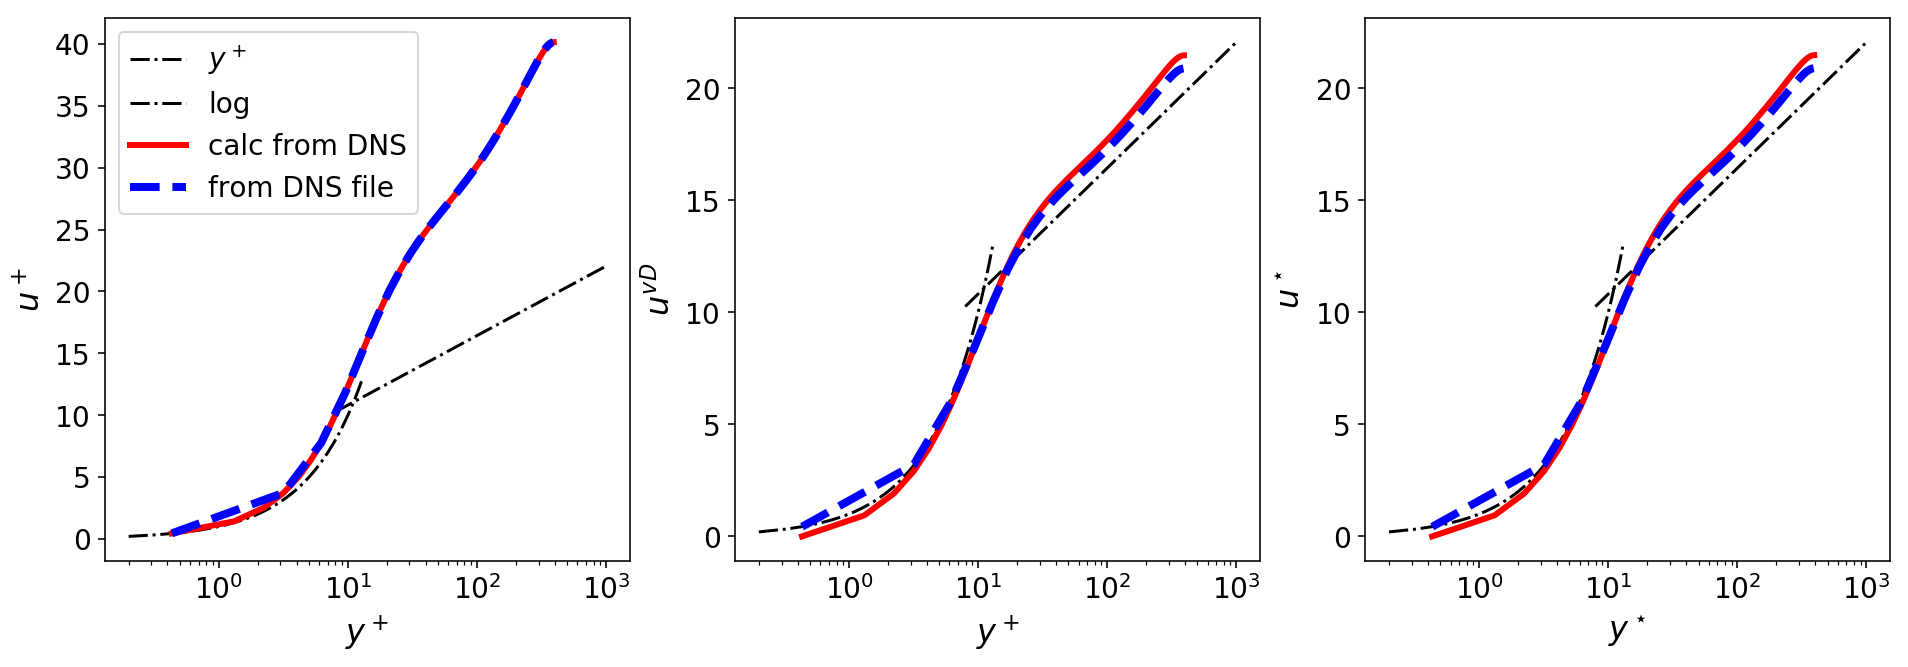

In [74]:
y     = DNS[:,0]
uplus = DNS[:,8]
rho   = DNS[:,5]
mu    = DNS[:,6]

n = np.size(y,0)

# model 1
ypl,uvd =  velTransVD(uplus,rho,ReTau,y)      # note, u is already u+ due to normalization
yst,ust = velTransSLS(uplus,rho,mu,ReTau,y)


# analytic results for viscous sub-layer
ypLam = np.linspace(0.2,13,100); 
    
# semi-empirical result for log-layer
ypTurb = np.linspace(0.9,3,20); 
upTurb = 1/0.41*np.log(np.power(10, ypTurb))+5.2

# model solution
plt.subplot(1,3, 1)
plt.semilogx(ypLam,ypLam,'k-.'); plt.semilogx(np.power(10, ypTurb), upTurb,'k-.')
plt.semilogx(ypl,uplus, 'r-',linewidth=3)
plt.plot(DNS[::3,1],DNS[::3,8],'b--',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^+$', fontsize=16); plt.ylabel('$u^+$', fontsize=16);
plt.legend(('$y^+$','log','calc from DNS','from DNS file'))

plt.subplot(1,3, 2)
plt.semilogx(ypLam,ypLam,'k-.'); plt.semilogx(np.power(10, ypTurb), upTurb,'k-.')
plt.semilogx(ypl,uvd,'r-',linewidth=3)
plt.plot(DNS[::3,1],DNS[::3,10],'b--',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^+$', fontsize=16); plt.ylabel('$u^{vD}$', fontsize=16);

plt.subplot(1,3, 3)
plt.semilogx(ypLam,ypLam,'k-.'); plt.semilogx(np.power(10, ypTurb), upTurb,'k-.')
plt.semilogx(yst,ust,'r-',linewidth=3)
plt.plot(DNS[::3,2],DNS[::3,11],'b--',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^\star$', fontsize=16); plt.ylabel('$u^\star$', fontsize=16);

